In [9]:
import random
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt

from os import listdir
from os.path import isfile, join
from pathlib import Path
import os
path = Path(os.getcwd())
os.chdir(path.parent.parent)
pd.set_option('display.max_columns', None)
onlyfiles = ['Chuhrov/thousand_arm_shiva/data/' +f for f in listdir('Chuhrov/thousand_arm_shiva/data') if isfile(join('Chuhrov/thousand_arm_shiva/data', f))]


In [11]:
df = pd.read_csv('Chuhrov/thousand_arm_shiva/data/SBER_H1.csv', parse_dates=['datetime'], index_col='datetime')
df = df.loc['2023-06-01 00:00:00':]
ind = df.index.to_list()

q = 'Chuhrov/thousand_arm_shiva/data/YNDX_H1.csv'

df = pd.read_csv(q, parse_dates=['datetime'], index_col='datetime')
df = df.reindex(ind)
df = df.fillna(method='ffill')
df = df.sort_index()
df = df.loc['2023-06-01 00:00:00':]
df

,open,high,low,close,volume
datetime,,,,,
2023-06-01 10:00:00,2328.0,2356.0,2318.0,2343.6,143039.0
2023-06-01 11:00:00,2343.2,2348.0,2333.2,2333.2,48477.0
2023-06-01 12:00:00,2333.2,2334.2,2304.8,2311.4,86184.0
2023-06-01 13:00:00,2313.2,2336.4,2294.8,2330.0,104030.0
2023-06-01 14:00:00,2329.2,2333.6,2316.0,2326.8,33793.0
...,...,...,...,...,...
2024-08-27 19:00:00,4092.2,4096.4,4071.2,4071.2,9576.0
2024-08-27 20:00:00,4092.2,4096.4,4071.2,4071.2,9576.0
2024-08-27 21:00:00,4092.2,4096.4,4071.2,4071.2,9576.0


In [15]:
data = {}

for stock_file in onlyfiles:
    df = pd.read_csv(stock_file, parse_dates=['datetime'], index_col='datetime')
    df = df.reindex(ind)
    df = df.fillna(method='ffill')
    df = df.sort_index()
    df = df.loc['2023-06-01 00:00:00':]
    if df['close'].isna().sum() == 0:
        df['return'] = df['close'].pct_change() # Calculate returns based on the close price
        data[stock_file] = df['return'].dropna() 
correct_stocks =  set(data.keys())

len(correct_stocks)

234

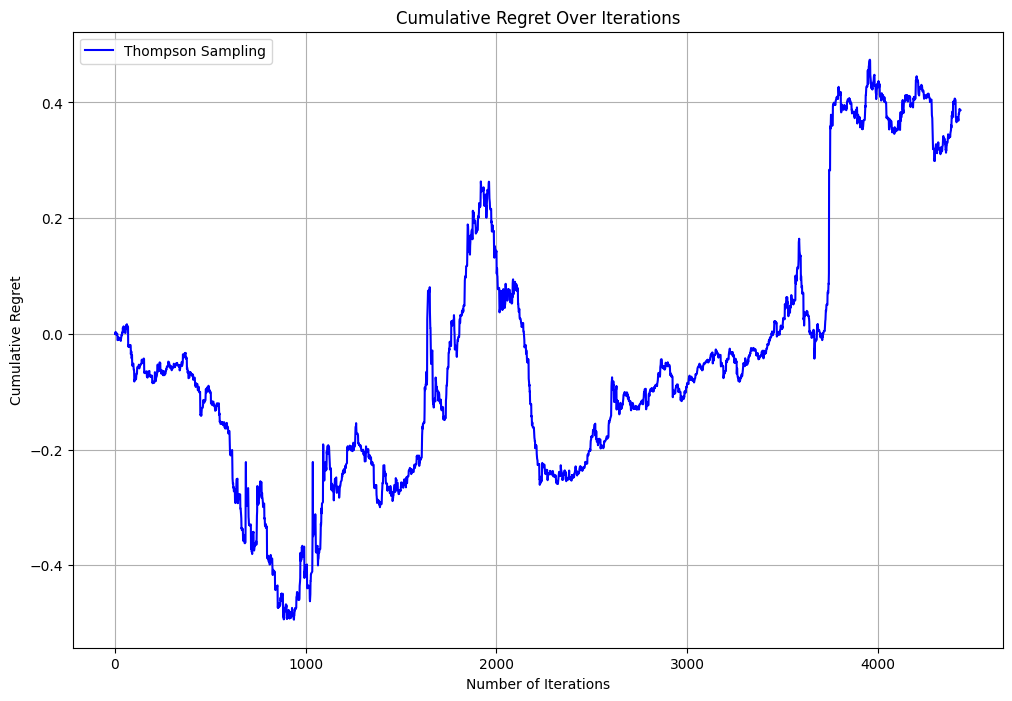

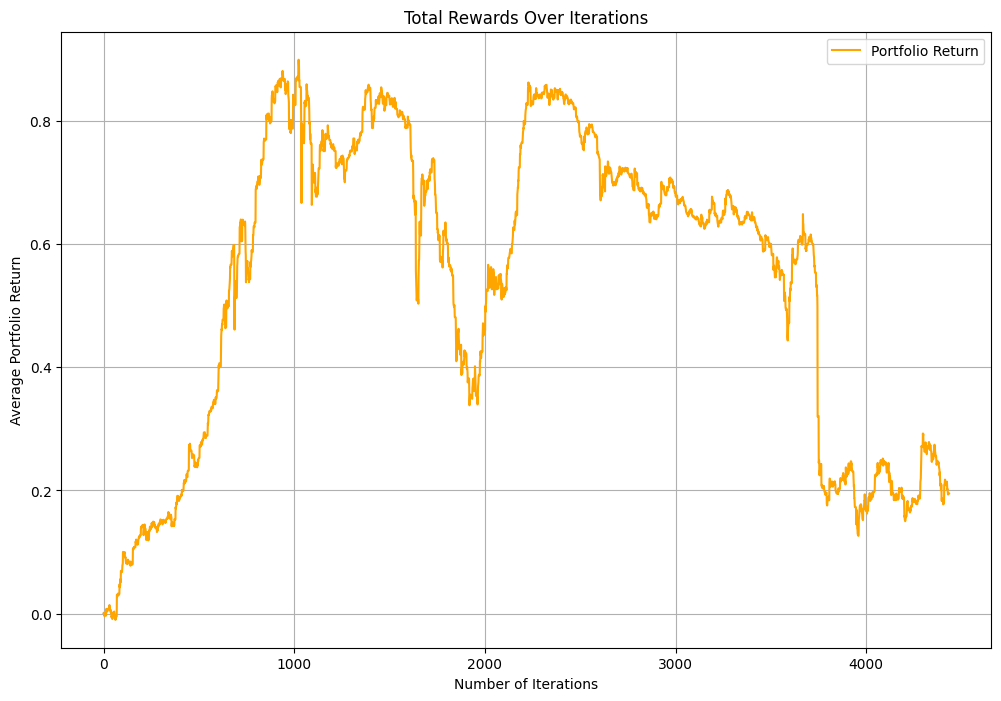

In [16]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

df = pd.read_csv('Chuhrov/thousand_arm_shiva/data/SBER_H1.csv', parse_dates=['datetime'], index_col='datetime')
df = df.loc['2023-06-01 00:00:00':]
ind = df.index.to_list()

# Strategy Abstract Class
class Strategy:
    def __init__(self, n_arms: int, n_portfolio: int, penalty: float, greed: float, greed_tempo: float):
        self.n_arms = n_arms
        self.n_portfolio = n_portfolio
        self.n_iters = 0
        self.arms_states = np.zeros(n_arms)  # State for each arm
        self.arms_actions = np.zeros(n_arms)  # Action counts for each arm
        
    def flush(self):
        self.n_iters = 0
        self.arms_states = np.zeros(self.n_arms)
        self.arms_actions = np.zeros(self.n_arms)
        
    def update_reward(self, arm: int, reward: float):
        self.n_iters += 1
        self.arms_states[arm] += reward
        self.arms_actions[arm] += 1
        
    def choose_arm(self):
        raise NotImplementedError


# Thompson Sampling Strategy
class Thompson(Strategy):
    def __init__(self, n_arms: int, n_portfolio: int, penalty: float, greed: float, greed_tempo: float):
        super().__init__(n_arms, n_portfolio, penalty, greed, greed_tempo)
        # Use dictionaries to store alphas and betas for each arm
        self.alphas = {i: [1.0] for i in range(n_arms)}  # Initialize with 1 to avoid zero
        self.betas = {i: [-1.0] for i in range(n_arms)}
        self.greed = greed
        self.greedness = {i: greed for i in range(n_arms)} # should be more then 0
        self.portfolio = []
        self.greed_tempo = greed_tempo
        self.penalty = penalty
        

    def choose_arm(self):
        # Sample a value from the beta distribution for each arm and select the best
        sampled_values = {i: np.random.beta(
                                            sum(self.alphas[i][:840]),  # в распределении учитываем последние 14 дней
                                            abs(sum(self.betas[i][:840])) # в распределении учитываем последние 14 дней
                                           ) 
                          for i in range(self.n_arms)}
        
        # Sort arms based on the sampled values to find the top `n_portfolio` arms
        best_arms = sorted(sampled_values, key=sampled_values.get, reverse=True)[:self.n_portfolio]
        
        self.portfolio = best_arms
        
        return best_arms

    def update_reward(self, arm: int, reward: float):
        # Ensure reward is clipped to [0, 1], if necessary
        # reward = max(0, min(1, reward))
        
        # Update alpha and beta based on the received reward
        if arm in self.portfolio:
            if reward <= 0:  # Consider a threshold for reward as failure (this might need adjustment)
                self.betas[arm].insert(0,reward)
                self.alphas[arm].insert(0,1e-20 )
                self.greedness[arm] = self.greed
            else:
                self.alphas[arm].insert(0,reward)
                self.betas[arm].insert(0,-1e-20)
                self.greedness[arm] = self.greed
        else:
            # Apply a penalty or adjustment for arms not in the portfolio 
            # try: 
            reward -= self.penalty / self.greedness[arm] # Apply penalty
            # except:
            #     print(arm)
            #     print(self.penalty)
            #     print(self.greedness[arm])
            #     print(self.greedness)
            #     reward -= self.penalty / self.greedness[arm]

            if reward  <= 0:
                self.betas[arm].insert(0,reward)
                self.alphas[arm].insert(0,1e-20 )
                if self.greedness[arm] > 1:
                    self.greedness[arm] -= self.greed_tempo
            else:
                self.alphas[arm].insert(0,reward )
                self.betas[arm].insert(0,-1e-20 )
                self.greedness[arm] += self.greed_tempo

        # Optionally, print or log the updated alpha/beta values for inspection
        # print(f"Updated for arm {arm}: alpha = {self.alphas[arm]}, beta = {self.betas[arm]}")

# Environment for Stock Market with CSV data
class StockMarketEnv:
    def __init__(self, stock_files: list):
        self.stock_data = self.load_stock_data(stock_files)
        self.n_arms = len(self.stock_data)
        self.portfolio = []
        
    def load_stock_data(self, stock_files):
        data = {}
        for stock_file in stock_files:
            df = pd.read_csv(stock_file, parse_dates=['datetime'], index_col='datetime')
            df = df.reindex(ind)
            df = df.fillna(method='ffill')
            df = df.sort_index()
            df = df.loc['2023-06-01 00:00:00':]
            if df['close'].isna().sum() == 0:
                df['return'] = df['close'].pct_change() # Calculate returns based on the close price
                data[stock_file] = df['return'].dropna()    # Keep only valid return
        return data
    
    def get_expected_returns(self, i):
        # посмотреть может брать не все, а последние N дней
        # Calculate expected returns for each stock
        if i <= 1260:
            return np.array([self.stock_data[file][:i].mean() for file in self.stock_data])
        else:
            return np.array([self.stock_data[file][i-1260:].mean() for file in self.stock_data])
    
    def pull_arm(self, arm_id: int, inde):
        # пуе a return for the specific stock in specific time moment
        stock_file = list(self.stock_data.keys())[arm_id]
        try: 
            return self.stock_data[stock_file][inde-1]
        except:
            print(self.stock_data[stock_file[inde-1]], inde)

# Bandit Mechanism
class Bandit:
    
    def __init__(self, env: StockMarketEnv, strategy: Strategy):
        self.env = env
        self.strategy = strategy
        
    def action(self, inde):
        arm = self.strategy.choose_arm()
        reward = self.env.pull_arm(arm, inde) # inde +1?
        self.strategy.update_reward(arm, reward)

        
strat = []

# Calculate Cumulative Regret and Collect Rewards
def calculate_regret(env: StockMarketEnv, strategy: Strategy):
    strategy.flush()
    bandit = Bandit(env, strategy)
    regrets = []
    total_rewards = []  # List to collect total rewards
    for i in range(len(ind)-2):
        expected_returns = env.get_expected_returns(i)  # Get expected returns
        optimal_return = np.mean(expected_returns)
        selected_stocks = bandit.strategy.choose_arm()  # Choose the best portfolio
        strat.append(selected_stocks)
        
        portfolio_return = np.mean([bandit.env.pull_arm(stock, i) for stock in selected_stocks])
        
        
        # portfolio_return = np.mean(portfolio_return)


        regrets.append(optimal_return-portfolio_return)
        
        # Store the total reward at this iteration
        total_rewards.append(portfolio_return)

        for stock in range(len(stock_files)):
            reward = bandit.env.pull_arm(stock, i)
            bandit.strategy.update_reward(stock, reward)
        
    return regrets, total_rewards

# Define the CSV files containing stocks data
# stock_files = onlyfiles  # Replace with your CSV paths
stock_files = correct_stocks

# Environment and Strategy Initialization
sm_env = StockMarketEnv(stock_files)  # Stock Market Environment
thompson = Thompson(sm_env.n_arms, n_portfolio=10, penalty=0.05, greed = 1, greed_tempo = 1)  # Thompson Sampling Strategy

# Regret Calculation
thompson_regrets, thompson_rewards = calculate_regret(sm_env, thompson)
df_regret = pd.DataFrame(None)
df_regret['regret'] = thompson_regrets
df_regret['regret_cum'] = df_regret['regret'].cumsum()
df_reward = pd.DataFrame(None)
df_reward['metric'] = thompson_rewards
df_reward['metric_cum'] = df_reward['metric'].cumsum()

# Plotting Regret
plt.figure(figsize=(12, 8))
plt.plot(df_regret['regret_cum'], label='Thompson Sampling', color='blue')
plt.title('Cumulative Regret Over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cumulative Regret')
plt.grid()
plt.legend()
plt.show()

# Plotting Rewards
plt.figure(figsize=(12, 8))
plt.plot(df_reward['metric_cum'], label='Portfolio Return', color='orange')
plt.title('Total Rewards Over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Portfolio Return')
plt.grid()
plt.legend()
plt.show()

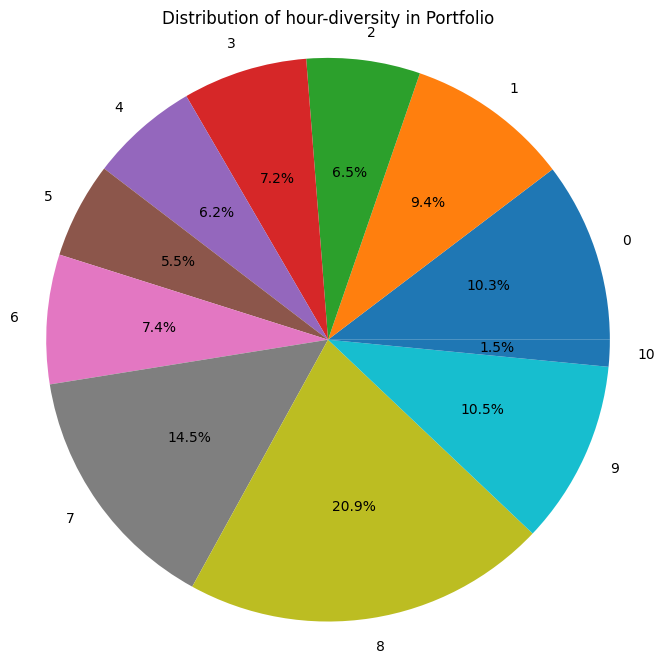

In [17]:
num_stocks_stayed = [sum(j in strat[i+1] for j in s) for i, s in enumerate(strat[:-2])]
stock_counts = []
categories = set(num_stocks_stayed)
for i in set(num_stocks_stayed):
    stock_counts.append(sum([j==i for j in num_stocks_stayed]))

# Create a bar chart
plt.figure(figsize=(8, 8))
plt.pie(stock_counts, labels=categories, autopct='%1.1f%%', startangle=0)

# Add a title
plt.title('Distribution of hour-diversity in Portfolio')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

plt.show()

In [ ]:
regretus = []
rewardus = []
for i in range(10000):
    sm_env = StockMarketEnv(stock_files)  # Stock Market Environment
    thompson = Thompson(sm_env.n_arms, n_portfolio=10, penalty=0.05, greed = 1, greed_tempo = 1)  # Thompson Sampling Strategy

    # Regret Calculation
    thompson_regrets, thompson_rewards = calculate_regret(sm_env, thompson)
    regretus.append(thompson_regrets[1:])
    rewardus.append(thompson_rewards[1:])

In [ ]:
sum(regretus[1:]) / len(regretus)

In [ ]:
sum(rewardus[1:]) / len(rewardus)